In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from scipy.interpolate import griddata, interp1d
from superrad import ultralight_boson as ub

#orig_path= "/Users/sebhoof/Research/BHSR/"
#sys.path.append("../code_matt/")
#from BH_functions import stellar_functions

from py.cfm import *
from py.constants import *
from py.bhsr import *
from py.bosenova import *
from py.kerr_bh import *
from py.plotting import *

set_style(gs=9, lts=9, lfs=8, lbls=9, tls=9)

!mkdir -p figures

### Compare BHSR rates

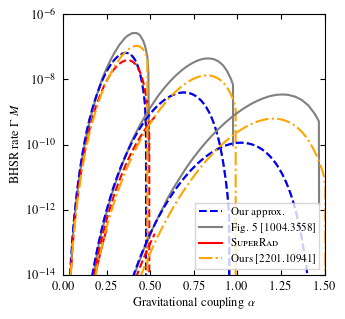

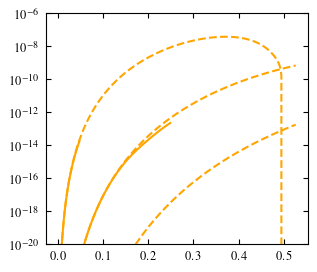

In [2]:
states = [(ell+1, ell, ell) for ell in range(1,4)]
astar0 = 0.999
mbh0 = 10.0 # Msol

def mu_to_alpha(mu, mbh=mbh0, units=1e-12):
    return alpha(mu*units, mbh)
def alpha_to_mu(alph, mbh=mbh0, units=1e-12):
    return alph/(units*rg(mbh))

"""
masha_bhsr_rates = []
for i in range(1,5):
    data = np.genfromtxt("data/1411_2263/ell_{:d}".format(i))
    masha_bhsr_rates.append(data)
""";

muvals_small = np.linspace(0.01, 7, 200)*1e-12
alphvals_small = mu_to_alpha(muvals_small, units=1)
muvals = np.linspace(0.01, 25, 250)*1e-12
alphvals = mu_to_alpha(muvals, units=1)
bc1 = ub.UltralightBoson(spin=0, model="non-relativistic")
bc2 = ub.UltralightBoson(spin=0, model="relativistic")

fig, ax = plt.subplots(figsize=(mnras_width,mnras_width))

for s in states:
    n, l, m = s
    # p0 = ax.plot(muvals/1e-12, GammaSR_nlm(muvals, mbh0, astar0, n, l, m)*rg(mbh0), 'r', label=r"Ours (Dettweiler)")
    grates = []
    for mu in muvals:
        _, om1 = omega_nlm_bxzh(mu, mbh0, astar0, n, l, m)
        grates.append(om1*rg(mbh0))
    d = np.genfromtxt("data/1004_3558/1004_3558_fig5_ell_{:d}_nr".format(l))
    p2 = ax.plot(d[:,0], d[:,1], '--', c='gray', label=r"Fig. 5 [1004.3558] (NR)")
    d = np.genfromtxt("data/1004_3558/1004_3558_fig5_ell_{:d}_r".format(l))
    p6 = ax.plot(d[:,0], d[:,1], '-', c='gray', label=r"Fig. 5 [1004.3558]")
    p1 = ax.plot(alphvals, GammaSR_nlm_nr(muvals, mbh0, astar0, n, l, m)*rg(mbh0), c='blue', ls='--', label=r"Our approx.")
    superrad_bhsr_rates1 = [GammaSR_nlm_superrad(mu, mbh0, astar0, bc1, m)*rg(mbh0) for mu in muvals_small]
    superrad_bhsr_rates2 = [GammaSR_nlm_superrad(mu, mbh0, astar0, bc2, m)*rg(mbh0) for mu in muvals_small]
    p3 = ax.plot(alphvals_small, superrad_bhsr_rates1, c='red', ls='--', label=r"\textsc{SuperRad} (NR)")
    p4 = ax.plot(alphvals_small, superrad_bhsr_rates2, c='red', ls='-', label=r"\textsc{SuperRad}")
    p5 = ax.plot(alphvals, grates, c='orange', ls='-.', label=r"Ours [2201.10941]")
ax.legend(handles=p1+p6+p4+p5, frameon=True)#, title=r"$M = {:.0f}\,M_\odot$, $a_\ast = {:.3f}$".format(mbh0, astar0))
#secax = ax.secondary_xaxis('top', functions=(alpha_to_mu, mu_to_alpha))
#secax.set_xlabel(r"ULB mass $\mu$ [$10^{-12}$ eV]")
ax.set_xlabel(r"Gravitational coupling $\alpha$")
ax.set_ylabel(r"BHSR rate $\Gamma\,M$")
ax.set_xlim([0, 1.5])
ax.set_ylim([1e-14, 1e-6])
#axset_xscale('log')
ax.set_yscale('log')
fig.savefig("figures/rate_comparison.pdf", backend='pgf')
plt.show()

for s in states:
    *_, m = s
    superrad_bhsr_rates1 = [GammaSR_nlm_superrad(mu, mbh0, astar0, bc1, m)*rg(mbh0) for mu in muvals_small]
    superrad_bhsr_rates2 = [GammaSR_nlm_superrad(mu, mbh0, astar0, bc2, m)*rg(mbh0) for mu in muvals_small]
    plt.plot(alphvals_small, superrad_bhsr_rates1, c='orange', ls='--')
    plt.plot(alphvals_small, superrad_bhsr_rates2, c='orange', ls='-')
plt.yscale('log')
plt.ylim([1e-20, 1e-6])
plt.show()

In [4]:
astar0 = 0.99
mbh0 = 10.0 # Msol
alpha0 = 0.7
mu0 = alpha_to_mu(alpha0, mbh=mbh0, units=1)
print("mu0 =", alpha0/rg(mbh0), "eV") # cf. Fig. 4, 0705.2880
root = find_root(mbh0, astar0, mu0, 2, 1, 1, verbose=True)
# print(root_equation([root.real, root.imag], mbh0, astar0, mu0, 1, 1))
print("om/mu = ", root.real/mu0, "gam/mu =", root.imag/mu0)
alpha0 = 0.421 # cf. Table I, 0705.2880
mu0 = alpha_to_mu(alpha0, mbh=mbh0, units=1)
print("mu0 =", mu0, "eV")
# mu0 = 0.39/rg(mbh0)
# alpha0 = mu_to_alpha(mu0, mbh=mbh0, units=1)
# print("alpha =", alpha0)
root = find_root(mbh0, astar0, mu0, 2, 1, 1, verbose=True)
print(root_equation([root.real, root.imag], mbh0, astar0, mu0, 1, 1))
print(mu0, root.real/mu0, root.imag/mu0)
print(omegaHyperfine(mu0, mbh0, astar0, 2, 1, 1)/mu0, GammaSR_nlm_nr(mu0, mbh0, astar0, 2, 1, 1)/mu0)

mu0 = 9.307344324363172e-12 eV
om/mu =  0.92072749375 gam/mu = 0.0
mu0 = 5.597702800795564e-12 eV
E VariableMetricBuilder Initial matrix not pos.def.
(5.447633483459258e-12+1.999127119497205e-18j)
(6.217248937900877e-15-6.328271240363392e-15j)
5.597702800795564e-12 0.9731909101506823 3.571334868319701e-07
0.9747637533862955 2.493699844062361e-08


omega_ours/mu0 = 0.9731909101506823
omega_Dolan/mu0 = 0.9730609675355426
omega_Baumann/mu0 = 0.9747637533862955


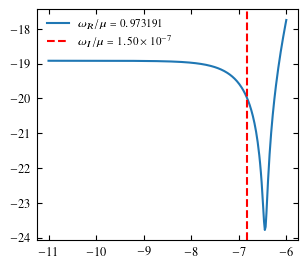

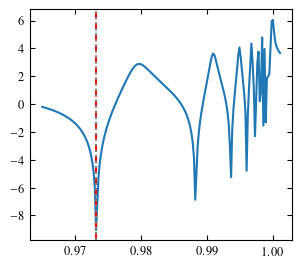

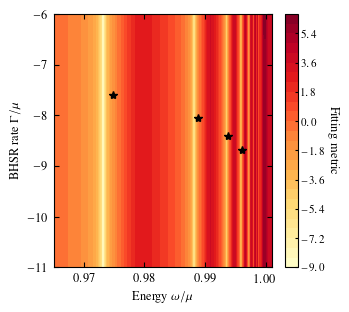

In [5]:
# See also https://arxiv.org/pdf/1212.1477.pdf
dat1 = np.genfromtxt("data/0705_2880/0705_2880_fig4_top.dat")
om_ref = interp1d(dat1[:,0], dat1[:,1])
print("omega_ours/mu0 =", root.real/mu0)
print("omega_Dolan/mu0 =", om_ref(alpha0))
print("omega_Baumann/mu0 =", omegaHyperfine(mu0, mbh0, astar0, 2, 1, 1)/mu0)

# omIvals = np.linspace(0, 1e-2, 200)*mu0
omIvals = np.logspace(-11, -6, 300)*mu0
lgIvals = np.log10(omIvals/mu0)
omRvals = np.linspace(0.965, 1.001, 200)*mu0
# lgRvals = np.log10(omRvals/mu0)
nvals = range(2,6)
omvals = [omegaHyperfine(mu0, mbh0, astar0, i, 1, 1)/mu0 for i in nvals]

plt.plot(lgIvals, [min_equation([0.9731908787952461*mu0, mu0*10**lg], mbh0, astar0, mu0, 1, 1) for lg in lgIvals], label=r"$\omega_R/\mu = 0.973191$")
# plt.plot(lgIvals, [min_equation([om_ref(alpha0)*mu0, mu0*10**lg], mbh0, astar0, mu0, 1, 1) for lg in lgIvals], label=r"$\omega_R\mu = 0.973$")
plt.gca().axvline(np.log10(1.5e-7), ls='--', c='r', label=r"$\omega_I/\mu = 1.50 \times 10^{-7}$")
plt.legend()
plt.show()

onedchi2 = [min_equation([omR, 1.5e-7/rg(mbh0)], mbh0, astar0, mu0, 1, 1) for omR in omRvals]
plt.plot(omRvals/mu0, onedchi2)
plt.gca().axvline(om_ref(alpha0), ls='--', c='r')
plt.gca().axvline(root.real/mu0, ls=':', c='grey')
plt.show()

x0 = np.array([om/mu0 for om in omRvals for _ in omIvals])
y0 = np.array([lg for _ in omRvals for lg in lgIvals])
z0 = np.array([min_equation([omR, omI], mbh0, astar0, mu0, 1, 1) for omR in omRvals for omI in omIvals])

npoints = 400

xi = np.linspace(x0.min(), x0.max(), npoints)
yi = np.linspace(y0.min(), y0.max(), npoints)
zi = griddata((x0, y0), z0, (xi[None,:], yi[:,None]), method='linear')

fig, ax = plt.subplots()

plt.contourf(xi, yi, zi, cmap='YlOrRd', levels=25, zorder=-9)
cs = plt.colorbar()
cs.ax.set_ylabel('Fitting metric', labelpad=12, rotation=270)
cs.ax.tick_params(labelsize=8, length=2, pad=2)
ax.set_rasterization_zorder(-1)
# ax.plot(lgomvals, np.log10(gammas), 'k--')
# print(omvals)
ax.plot(omvals, np.log10([GammaSR_nlm_nr(mu0, mbh0, astar0, i, 1, 1)/mu0 for i in nvals]), '*', c='k')
ax.plot(omRvals/mu0, 8.0*np.log10(rg(mbh0)*omRvals), 'k:', label=r"Dettweiler's approx.") # Im(omega/mu) ~ alpha^8/24

ax.set_xlabel(r"Energy $\omega/\mu$")
ax.set_ylabel(r"BHSR rate $\Gamma/\mu$")
ax.set_xlim([xi.min(), xi.max()])
ax.set_ylim([yi.min(), yi.max()])

fig.tight_layout(pad=0.3)
plt.savefig("figures/energy_levels_2d.pdf", backend='pgf')
plt.show()

/Users/sebhoof/Software/bhsr/py/bhsr.py:191: RuntimeWarning: invalid value encountered in scalar divide
  delta1 = 0.5*(q/eps - eps - p*2j)*kappab_term*gam_terms


E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.


/Users/sebhoof/Software/bhsr/py/bhsr.py:191: RuntimeWarning: invalid value encountered in scalar divide
  delta1 = 0.5*(q/eps - eps - p*2j)*kappab_term*gam_terms


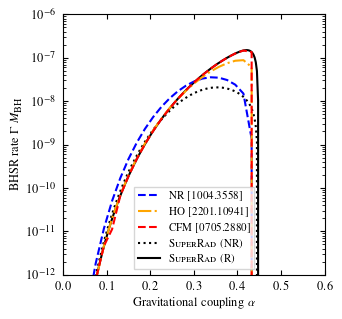

In [9]:
muvals = np.linspace(0, 6e-12, 25)
alphvals = mu_to_alpha(muvals, units=1)

optvals = [find_root(mbh0, astar0, mu, 2, 1, 1) for mu in muvals]
omRvals = np.array([z.real for z in optvals])
omIvals = np.array([z.imag for z in optvals])*rg(mbh0)
superrad_bhsr_rates1 = [GammaSR_nlm_superrad(mu, mbh0, astar0, bc1, 1)*rg(mbh0) for mu in muvals_small]
superrad_bhsr_rates2 = [GammaSR_nlm_superrad(mu, mbh0, astar0, bc2, 1)*rg(mbh0) for mu in muvals_small]

fig, ax = plt.subplots(figsize=(mnras_width,mnras_width))

p4 = ax.plot(alphvals_small, superrad_bhsr_rates1, c='k', ls=':', label=r"\textsc{SuperRad} (NR)")
p5 = ax.plot(alphvals_small, superrad_bhsr_rates2, c='k', ls='-', label=r"\textsc{SuperRad} (R)")
grates = []
for mu in muvals:
    _, om1 = omega_nlm_bxzh(mu, mbh0, astar0, 2, 1, 1)
    grates.append(om1*rg(mbh0))
p1 = ax.plot(alphvals, GammaSR_nlm_nr(muvals, mbh0, astar0, 2, 1, 1)*rg(mbh0), c='blue', ls='--', label=r"NR [1004.3558]")
p2 = ax.plot(alphvals, grates, c='orange', ls='-.', label=r"HO [2201.10941]")
p3 = ax.plot(alphvals, omIvals, c='red', ls='--', label=r"CFM [0705.2880]")
ax.legend(handles=p1+p2+p3+p4+p5, frameon=True)#, title=r"$M = {:.0f}\,M_\odot$, $a_\ast = {:.3f}$".format(mbh0, astar0))
ax.set_xlabel(r"Gravitational coupling $\alpha$")
ax.set_ylabel(r"BHSR rate $\Gamma\,M_\text{BH}$")
ax.set_xlim([0, 0.6])
ax.set_ylim([1e-12, 1e-6])
#axset_xscale('log')
ax.set_yscale('log')
fig.savefig("figures/rate_comparison_211.pdf", backend='pgf')
plt.show()

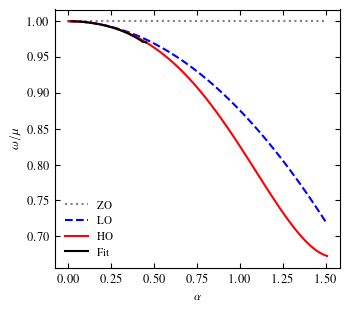

In [7]:
# Check energy levels

fig, ax = plt.subplots()

muvals1 = np.linspace(1e-16, 20e-12, 100)
alphvals1 = muvals1*rg(mbh0)
ax.plot(alphvals1, [1]*len(alphvals1), ':', c='grey', label="ZO")
ax.plot(alphvals1, omegaLO(muvals1, mbh0, 2)/muvals1, 'b--', label="LO")
ax.plot(alphvals1, omegaHyperfine(muvals1, mbh0, astar0, 2, 1, 1)/muvals1, 'r-', label="HO")
ax.plot(alphvals, omRvals/muvals, 'k-', label="Fit")

ax.legend()
ax.set_xlabel(r"$\alpha$")
ax.set_ylabel(r"$\omega/\mu$")
# ax.set_xscale('log')
# ax.set_yscale('log')

fig.tight_layout(pad=0.3)
plt.show()

### Plot some Regge slopes for our BHSR rates

In [ ]:
ma_test = 7e-12
states = np.array([(i,j,j) for i in range(7) for j in range(1,i)])

# Compute Regge slopes for our SR rate approx and many states

m_bh_vals = np.arange(-1, 2, 0.02)
ma0 = 4.3e-12
a_vals_2 = compute_regge_slopes(ma0, 10**m_bh_vals, states)
approx_regge_slope = interp1d(m_bh_vals, [np.nanmin(a) for a in a_vals_2])

foo = lambda mu, mbh, a: GammaSR_nlm_nr(mu, mbh, a)
a_vals_3 = compute_regge_slopes_given_rate(ma0, 10**m_bh_vals, foo)

# Compare to the final spin from superrad
# N.B. Superrad evolves the spin until there is 1 boson left in the cloud!
# This can leads to an evolution over time scales longer than the age of the BH etc.

a_vals_4 = []
bc = ub.UltralightBoson(spin=0, model="relativistic")
for mbh in 10**m_bh_vals:
   try:
      wf = bc.make_waveform(mbh, 0.99, ma0, units="physical")
      a_vals_4.append(wf.spin_bh_final())
   except:
      a_vals_4.append(np.nan)

In [ ]:
cond = (m_bh_vals > 0)

fig, ax = plt.subplots()

for i,s in enumerate(states):
    p1 = ax.plot(m_bh_vals, a_vals_2[:,i], c='gray', ls=':') #, label='$|{:d}{:d}{:d}\\rangle$'.format(*s))
p1 = ax.plot(m_bh_vals, approx_regge_slope(m_bh_vals), c='k', ls='-', label='Our approx')
p2 = ax.plot(m_bh_vals, a_vals_3, c='blue', lw=1.5, label=r"\texttt{superrad}")
p3 = ax.plot(m_bh_vals, a_vals_4, c='red', lw=1.5, ls='--', label=r"\texttt{superrad} ($a_\mathrm{fin}$)")

ax.set_xlabel('BH mass $\log_{10}(M/M_\odot)$')
ax.set_ylabel('Dimensionless BH spin $a_*$')
ax.set_ylim([0,1])
#ax.set_xlim([-1,2])

leg = ax.legend(handles=p1+p2+p3, frameon=False, loc=4, title='$m_a = {}\,$eV'.format(sci_format(ma_test)), fontsize=6)
#leg.get_title().set_fontsize('8')

fig.tight_layout()
fig.savefig("figures/regge_slope.pdf", dpi=300, backend='pgf')
plt.show()